# Groundwater Nitrate Contamination Mapping

This notebook simulates spatial groundwater well data, trains a Random Forest model to predict nitrate concentrations, and visualizes contamination risk.

In [4]:
%pip install numpy pandas geopandas shapely scikit-learn matplotlib pyproj rasterio

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 5.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   --------- ------------------------------ 1.6/6.3 MB 7.6 MB/s eta 0:00:01
   ----------------------- ---------------- 3.7/6.3 MB 8.7 MB/s eta 0:00:01
   ---------------------------------- ----- 5.5/6.3 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   --- -------


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box, LineString
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


In [6]:
# Optional raster export

try:
    import rasterio
    from rasterio.transform import from_origin
    RASTERIO_OK = True
except Exception:
    RASTERIO_OK = False
np.random.seed(42)

In [7]:
# -----------------------------

# 1) Define study area & sources

# -----------------------------

MIN_LON, MAX_LON = 5.0, 5.4
MIN_LAT, MAX_LAT = 6.2, 6.6
study_area = box(MIN_LON, MIN_LAT, MAX_LON, MAX_LAT)
study_gdf = gpd.GeoDataFrame(geometry=[study_area], crs="EPSG:4326")
source_points = [
    Point(5.08, 6.55),
    Point(5.32, 6.28),
    Point(5.22, 6.42),
]

sources_gdf = gpd.GeoDataFrame({"source_id":[1,2,3]}, geometry=source_points, crs="EPSG:4326")
river_coords = [(5.0, 6.25), (5.08, 6.3), (5.15, 6.33), (5.23, 6.36), (5.32, 6.38), (5.4, 6.4), (5.4, 6.55)]
river_line = gpd.GeoSeries([LineString(river_coords)], crs="EPSG:4326")


In [8]:
# -----------------------------

# 2) Generate synthetic wells

# -----------------------------

N_WELLS = 450
well_lons = np.random.uniform(MIN_LON, MAX_LON, N_WELLS)
well_lats = np.random.uniform(MIN_LAT, MAX_LAT, N_WELLS)
well_points = [Point(xy) for xy in zip(well_lons, well_lats)]
landuse_categories = ["agriculture", "urban", "forest", "wetland"]
landuse = np.random.choice(landuse_categories, N_WELLS, p=[0.45, 0.25, 0.25, 0.05])
soil_perm = np.clip(np.random.normal(0.5, 0.2, N_WELLS), 0.05, 0.95)
rainfall_mm = np.random.normal(2400, 200, N_WELLS)
depth_to_water_m = np.clip(np.random.normal(12, 5, N_WELLS), 1, 40)
well_depth_m = np.clip(depth_to_water_m + np.random.normal(20, 10, N_WELLS), 10, 120)

def min_distance_to_sources(pt: Point, source_list):
    return min(pt.distance(s) for s in source_list)

dist_src = np.array([min_distance_to_sources(p, source_points) for p in well_points])
dist_riv = np.array([p.distance(river_line.iloc[0]) for p in well_points])
landuse_factor = np.select(
    [landuse == "agriculture", landuse == "urban", landuse == "forest", landuse == "wetland"],
    [1.0, 0.6, 0.3, 0.5], default=0.4
)

dist_src_safe = np.maximum(dist_src, 1e-4)
dist_riv_safe = np.maximum(dist_riv, 1e-4)
nitrate = (
    80.0 * np.exp(-dist_src_safe * 12) +
    20.0 * np.exp(-dist_riv_safe * 8) +
    35.0 * landuse_factor * soil_perm +
    0.01 * (rainfall_mm - 2200) -
    0.8 * depth_to_water_m +
    np.random.normal(0, 6, N_WELLS)
)

nitrate = np.clip(nitrate, 0, None)
contam_flag = (nitrate > 50).astype(int)
wells = gpd.GeoDataFrame({
    "landuse": landuse,
    "soil_perm": soil_perm,
    "rainfall_mm": rainfall_mm,
    "depth_to_water_m": depth_to_water_m,
    "well_depth_m": well_depth_m,
    "dist_to_source_deg": dist_src,
    "dist_to_river_deg": dist_riv,
    "nitrate_mgL": nitrate,
    "contam_flag": contam_flag
}, geometry=well_points, crs="EPSG:4326")

In [9]:
# -----------------------------

# 3) Model Training

# -----------------------------

wells_df = pd.get_dummies(wells.drop(columns="geometry"), columns=["landuse"], drop_first=False)

feature_cols = [
    "soil_perm", "rainfall_mm", "depth_to_water_m", "well_depth_m",
    "dist_to_source_deg", "dist_to_river_deg"
] + [c for c in wells_df.columns if c.startswith("landuse_")]

X = wells_df[feature_cols].values
y = wells_df["nitrate_mgL"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Model performance:")
print(f"R^2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f} mg/L")

Model performance:
R^2: 0.822
MAE: 6.459 mg/L


In [10]:
# -----------------------------

# 4) Prediction Grid

# -----------------------------

RES = 0.004
xs = np.arange(MIN_LON, MAX_LON + RES, RES)
ys = np.arange(MIN_LAT, MAX_LAT + RES, RES)
xx, yy = np.meshgrid(xs, ys)
grid_pts = [Point(float(x), float(y)) for x, y in zip(xx.ravel(), yy.ravel())]
grid_dist_src = np.array([min_distance_to_sources(p, source_points) for p in grid_pts])
grid_dist_riv = np.array([p.distance(river_line.iloc[0]) for p in grid_pts])

def smooth_field(coords, base, scale, noise=0.0):
    lon, lat = coords[:, 0], coords[:, 1]
    return (base + scale * np.sin((lon - MIN_LON) * 8) + scale * 0.7 * np.cos((lat - MIN_LAT) * 9) + np.random.normal(0, noise, len(coords)))

coords = np.column_stack([xx.ravel(), yy.ravel()])
grid_soil_perm = np.clip(smooth_field(coords, 0.55, 0.20, noise=0.02), 0.05, 0.95)
grid_rainfall = smooth_field(coords, 2400, 120, noise=5.0)
grid_dtw = np.clip(smooth_field(coords, 14, 4, noise=0.8), 1, 40)
grid_well_depth = np.clip(grid_dtw + smooth_field(coords, 25, 8, noise=1.0), 10, 120)
grid_landuse = np.empty(len(grid_pts), dtype=object)
bands = np.digitize(coords[:, 1], np.linspace(MIN_LAT, MAX_LAT, 5))

for i, b in enumerate(bands):
    if b == 1: grid_landuse[i] = "wetland"
    elif b == 2: grid_landuse[i] = "forest"
    elif b == 3: grid_landuse[i] = "agriculture"
    else: grid_landuse[i] = "urban"

grid_gdf = gpd.GeoDataFrame({
    "soil_perm": grid_soil_perm,
    "rainfall_mm": grid_rainfall,
    "depth_to_water_m": grid_dtw,
    "well_depth_m": grid_well_depth,
    "dist_to_source_deg": grid_dist_src,
    "dist_to_river_deg": grid_dist_riv,
    "landuse": grid_landuse
}, geometry=grid_pts, crs="EPSG:4326")

grid_df = pd.get_dummies(grid_gdf.drop(columns="geometry"), columns=["landuse"], drop_first=False)

for col in [c for c in wells_df.columns if c.startswith("landuse_")]:
    if col not in grid_df.columns:
        grid_df[col] = 0

extra_cols = [c for c in grid_df.columns if c.startswith("landuse_") and c not in wells_df.columns]
grid_df = grid_df.drop(columns=extra_cols)
grid_X = grid_df[feature_cols].values
grid_pred = model.predict(grid_X)
prob_exceed = 1 / (1 + np.exp(-(grid_pred - 50.0) / 6.0))

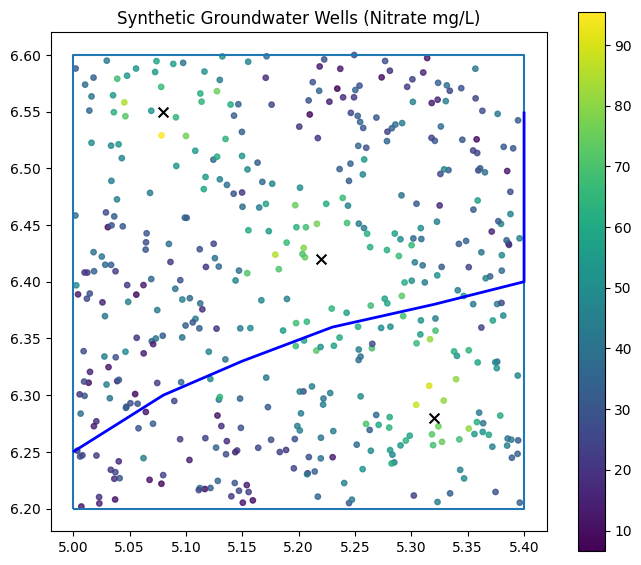

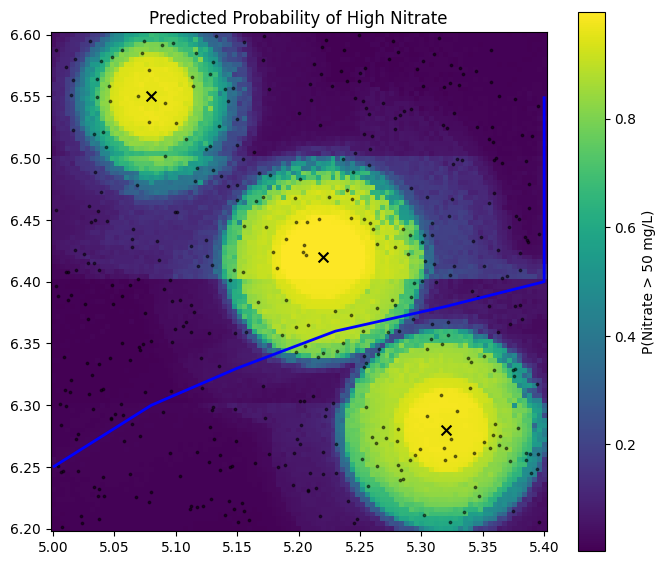

In [11]:
# -----------------------------

# 5) Visualization... 

# -----------------------------

fig1, ax1 = plt.subplots(figsize=(8, 7))
study_gdf.boundary.plot(ax=ax1)
wells.plot(ax=ax1, column="nitrate_mgL", legend=True, markersize=15, alpha=0.8)
sources_gdf.plot(ax=ax1, color="black", markersize=50, marker="x")
river_line.plot(ax=ax1, color="blue", linewidth=2)
ax1.set_title("Synthetic Groundwater Wells (Nitrate mg/L)")
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 7))
Zp = prob_exceed.reshape(len(ys), len(xs))
im = ax2.pcolormesh(xs, ys, Zp, shading="auto")
plt.colorbar(im, ax=ax2, label="P(Nitrate > 50 mg/L)")
wells.plot(ax=ax2, color="k", markersize=3, alpha=0.5)
sources_gdf.plot(ax=ax2, color="black", markersize=50, marker="x")
river_line.plot(ax=ax2, color="blue", linewidth=2)
ax2.set_title("Predicted Probability of High Nitrate")
plt.show()